# Data Visualization

Selected frames shape: (6, 512, 3)
Standardized frames shape: (6, 512, 3)


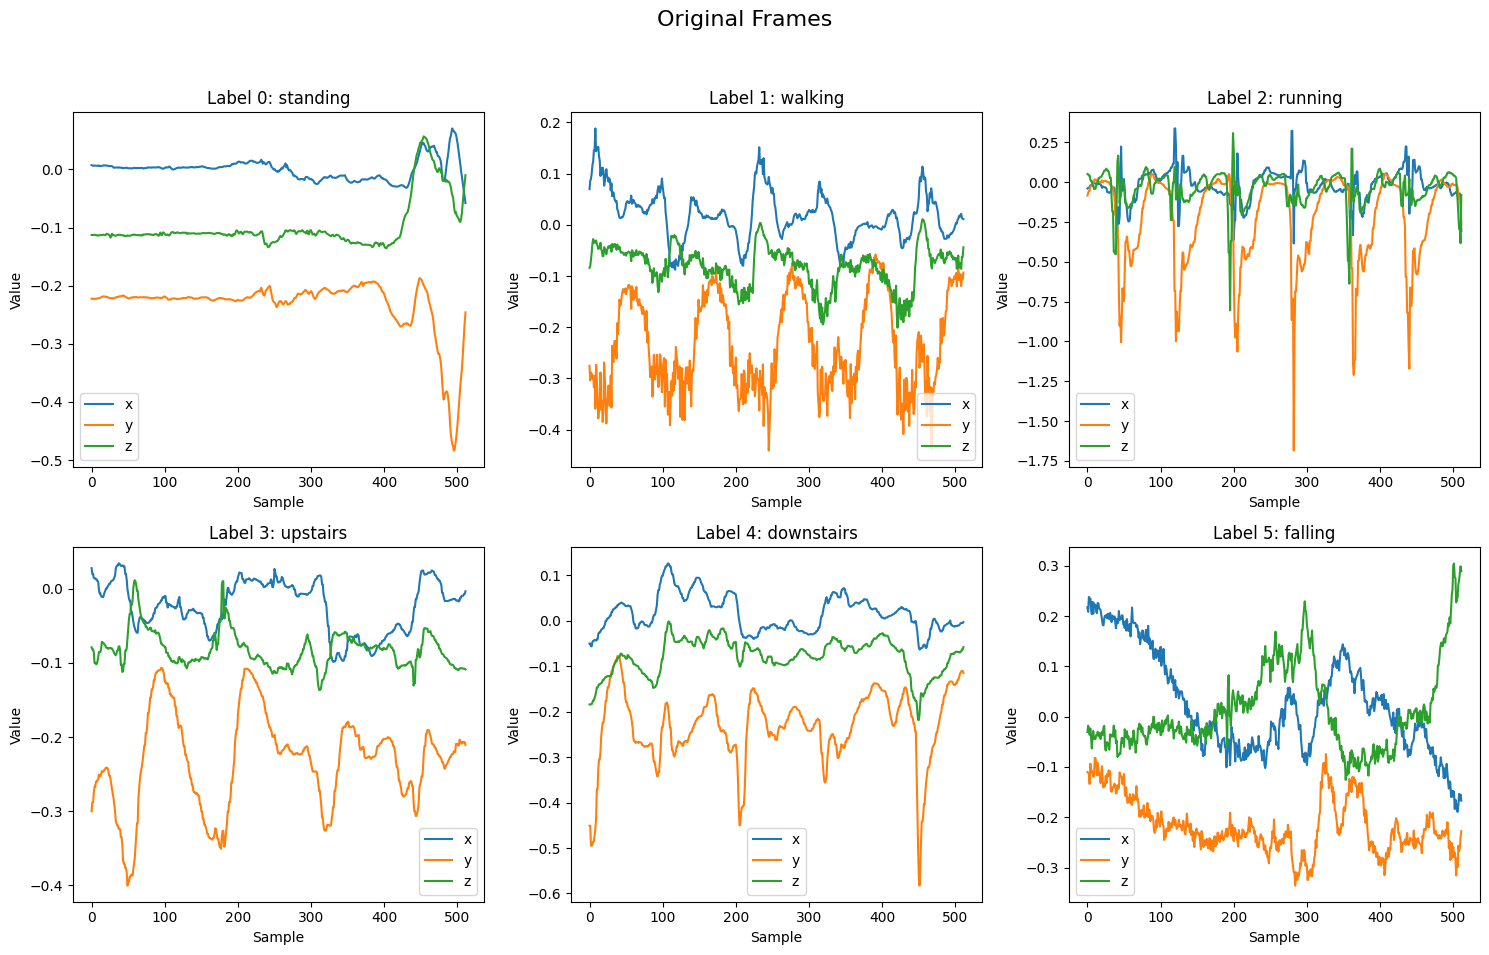

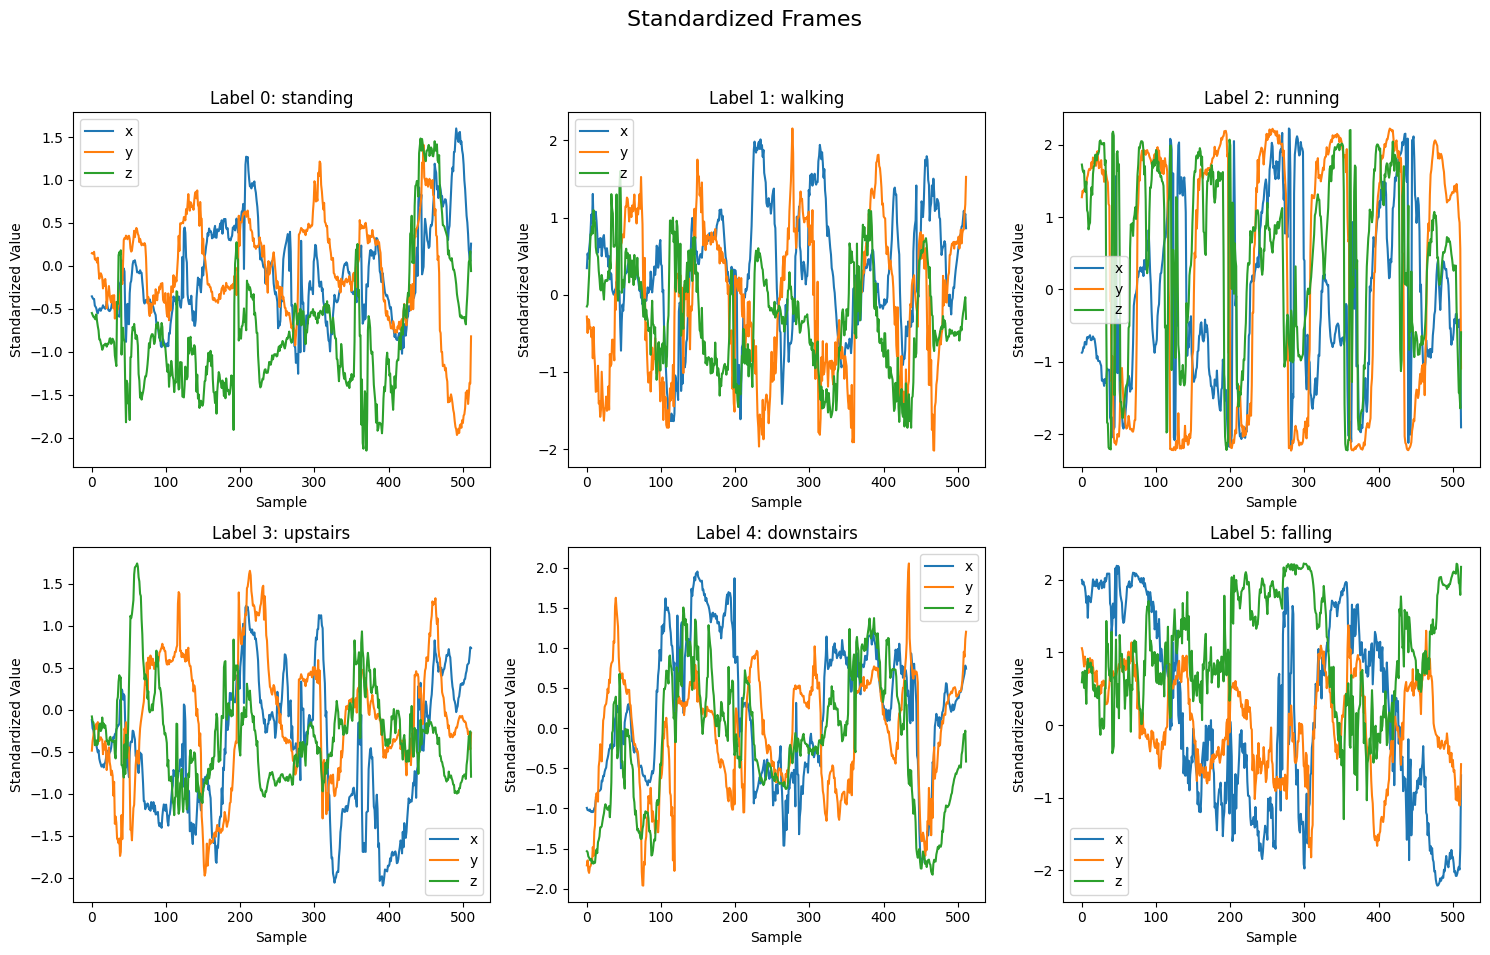

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data_dict = np.load('dataset.npy', allow_pickle=True).item()

all_frames = data_dict['frames']
all_labels = data_dict['labels']

label_names = ['standing', 'walking', 'running', 'upstairs', 'downstairs', 'falling']

selected_frames = []
selected_labels = []
for label in range(6):
    label_indices = np.where(all_labels == label)[0]
    selected_index = np.random.choice(label_indices)
    selected_frames.append(all_frames[selected_index])
    selected_labels.append(label)

selected_frames = np.array(selected_frames)
selected_labels = np.array(selected_labels)

scaler = StandardScaler()
selected_frames_flat = selected_frames.reshape(selected_frames.shape[0], -1)
standardized_frames_flat = scaler.fit_transform(selected_frames_flat)
standardized_frames = standardized_frames_flat.reshape(selected_frames.shape)

print(f'Selected frames shape: {selected_frames.shape}')
print(f'Standardized frames shape: {standardized_frames.shape}')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    ax = axes[i // 3, i % 3]
    ax.plot(selected_frames[i][:, 0], label='x')
    ax.plot(selected_frames[i][:, 1], label='y')
    ax.plot(selected_frames[i][:, 2], label='z')
    ax.set_title(f'Label {selected_labels[i]}: {label_names[selected_labels[i]]}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Value')
    ax.legend()

fig.suptitle('Original Frames', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    ax = axes[i // 3, i % 3]
    ax.plot(standardized_frames[i][:, 0], label='x')
    ax.plot(standardized_frames[i][:, 1], label='y')
    ax.plot(standardized_frames[i][:, 2], label='z')
    ax.set_title(f'Label {selected_labels[i]}: {label_names[selected_labels[i]]}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Standardized Value')
    ax.legend()

fig.suptitle('Standardized Frames', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# t-SNE visualization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64
batch_size_ft = 64
num_epochs_ft = 500

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=1):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return adj_matrix

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.indices = np.arange(len(features))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.indices[idx]

train_features, test_features, train_labels, test_labels = train_test_split(
    all_features, all_labels.cpu().numpy(), test_size=0.05, random_state=42, stratify=all_labels.cpu().numpy()
)

train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

train_adj = create_adj_matrix(train_labels.cpu().numpy())

train_adj_np = train_adj.copy()
num_edges = int(np.sum(train_adj_np) / 2)
num_disrupt = int(1 * num_edges)

edges = np.array(np.triu_indices(train_adj_np.shape[0], 1)).T
np.random.shuffle(edges)

disrupted_edges = edges[:num_disrupt]

for edge in disrupted_edges:
    train_adj_np[edge[0], edge[1]] = 0
    train_adj_np[edge[1], edge[0]] = 0

train_adj = torch.tensor(train_adj_np, dtype=torch.float32).to(device)

train_dataset = CustomDataset(train_features, train_labels)
train_loader_ft = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_ft, shuffle=True)

joint_losses = []
feature_reconstruction_losses = []
neighborhood_reconstruction_losses = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_joint_loss = 0.0
    running_feature_reconstruction_loss = 0.0
    running_neighborhood_reconstruction_loss = 0.0
    for data, labels, indices in train_loader_ft:
        optimizer_ft.zero_grad()
        z, x_reconstructed, adj_pred = feature_transformer(data)
        batch_adj = train_adj[indices][:, indices]
        joint_loss, feature_reconstruction_loss, neighborhood_reconstruction_loss = joint_loss_function(data, x_reconstructed, batch_adj, adj_pred)
        joint_loss.backward()
        optimizer_ft.step()
        running_joint_loss += joint_loss.item() * data.size(0)
        running_feature_reconstruction_loss += feature_reconstruction_loss.item() * data.size(0)
        running_neighborhood_reconstruction_loss += neighborhood_reconstruction_loss.item() * data.size(0)
    
    avg_joint_loss = running_joint_loss / len(train_loader_ft.dataset)
    avg_feature_reconstruction_loss = running_feature_reconstruction_loss / len(train_loader_ft.dataset)
    avg_neighborhood_reconstruction_loss = running_neighborhood_reconstruction_loss / len(train_loader_ft.dataset)
    joint_losses.append(avg_joint_loss)
    feature_reconstruction_losses.append(avg_feature_reconstruction_loss)
    neighborhood_reconstruction_losses.append(avg_neighborhood_reconstruction_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Joint Loss: {avg_joint_loss:.4f}, Feature Reconstruction Loss: {avg_feature_reconstruction_loss:.4f}, Neighborhood Reconstruction Loss: {avg_neighborhood_reconstruction_loss:.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

train_features_encoded = feature_transformer.encoder(train_features).detach().cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
train_features_2d = tsne.fit_transform(train_features_encoded)

train_labels_np = train_labels.cpu().numpy()

plt.figure(figsize=(10, 8))
for class_label in np.unique(train_labels_np):
    indices = np.where(train_labels_np == class_label)
    plt.scatter(train_features_2d[indices, 0], train_features_2d[indices, 1], label=f'Class {class_label}', alpha=0.5)

plt.title('t-SNE visualization of encoded features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

# Autoencoder

Using device: cuda
Epoch 1/200, Train Loss: 0.4743, Test Loss: 0.3057
Epoch 2/200, Train Loss: 0.2774, Test Loss: 0.2349
Epoch 3/200, Train Loss: 0.2147, Test Loss: 0.2035
Epoch 4/200, Train Loss: 0.1897, Test Loss: 0.1773
Epoch 5/200, Train Loss: 0.1600, Test Loss: 0.1625
Epoch 6/200, Train Loss: 0.1508, Test Loss: 0.1541
Epoch 7/200, Train Loss: 0.1367, Test Loss: 0.1428
Epoch 8/200, Train Loss: 0.1253, Test Loss: 0.1512
Epoch 9/200, Train Loss: 0.1304, Test Loss: 0.1403
Epoch 10/200, Train Loss: 0.1208, Test Loss: 0.1324
Epoch 11/200, Train Loss: 0.1060, Test Loss: 0.1186
Epoch 12/200, Train Loss: 0.0950, Test Loss: 0.1080
Epoch 13/200, Train Loss: 0.0913, Test Loss: 0.1172
Epoch 14/200, Train Loss: 0.0944, Test Loss: 0.1063
Epoch 15/200, Train Loss: 0.0896, Test Loss: 0.1067
Epoch 16/200, Train Loss: 0.0797, Test Loss: 0.0971
Epoch 17/200, Train Loss: 0.0745, Test Loss: 0.0941
Epoch 18/200, Train Loss: 0.0703, Test Loss: 0.0923
Epoch 19/200, Train Loss: 0.0742, Test Loss: 0.0927
Ep

Epoch 159/200, Train Loss: 0.0434, Test Loss: 0.0627
Epoch 160/200, Train Loss: 0.0405, Test Loss: 0.0665
Epoch 161/200, Train Loss: 0.0429, Test Loss: 0.0728
Epoch 162/200, Train Loss: 0.0409, Test Loss: 0.0579
Epoch 163/200, Train Loss: 0.0344, Test Loss: 0.0567
Epoch 164/200, Train Loss: 0.0324, Test Loss: 0.0569
Epoch 165/200, Train Loss: 0.0331, Test Loss: 0.0550
Epoch 166/200, Train Loss: 0.0351, Test Loss: 0.0598
Epoch 167/200, Train Loss: 0.0427, Test Loss: 0.0713
Epoch 168/200, Train Loss: 0.0430, Test Loss: 0.0640
Epoch 169/200, Train Loss: 0.0389, Test Loss: 0.0597
Epoch 170/200, Train Loss: 0.0398, Test Loss: 0.0603
Epoch 171/200, Train Loss: 0.0416, Test Loss: 0.0638
Epoch 172/200, Train Loss: 0.0440, Test Loss: 0.0695
Epoch 173/200, Train Loss: 0.0406, Test Loss: 0.0634
Epoch 174/200, Train Loss: 0.0406, Test Loss: 0.0611
Epoch 175/200, Train Loss: 0.0403, Test Loss: 0.0642
Epoch 176/200, Train Loss: 0.0381, Test Loss: 0.0605
Epoch 177/200, Train Loss: 0.0361, Test Loss: 

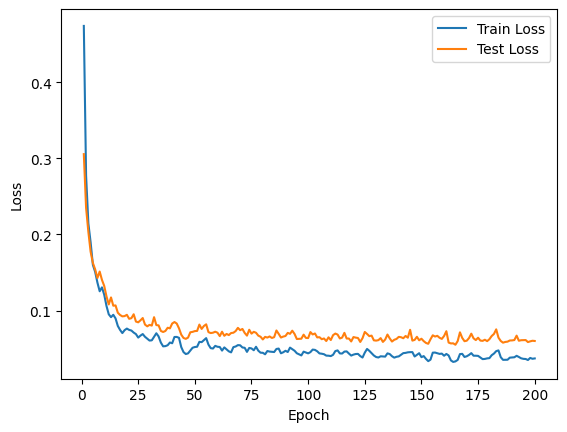

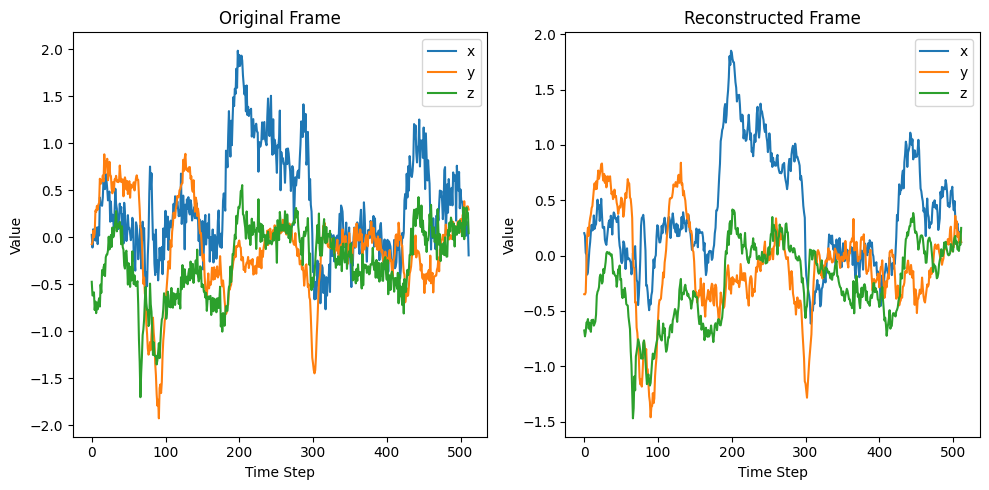

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

train_frames, test_frames, train_labels, test_labels = train_test_split(all_frames, all_labels, test_size=0.3, random_state=42)

train_frames = torch.tensor(train_frames, dtype=torch.float32).to(device)
test_frames = torch.tensor(test_frames, dtype=torch.float32).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = num_timesteps * num_features
encoding_dim = 64
learning_rate = 0.001
num_epochs = 200
batch_size = 32

model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_frames, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_frames, batch_size=batch_size, shuffle=False)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.view(data.size(0), -1)
            output = model(data)
            loss = criterion(output, data)
            test_loss += loss.item() * data.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

random_index = np.random.randint(0, len(test_frames))
random_frame = test_frames[random_index].view(1, -1)

model.eval()
with torch.no_grad():
    encoded_frame = model.encoder(random_frame)
    decoded_frame = model.decoder(encoded_frame)

original_frame = random_frame.cpu().view(num_timesteps, num_features).numpy()
reconstructed_frame = decoded_frame.cpu().view(num_timesteps, num_features).numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(original_frame)
plt.title('Original Frame')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend(['x', 'y', 'z'])

plt.subplot(1, 2, 2)
plt.plot(reconstructed_frame)
plt.title('Reconstructed Frame')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend(['x', 'y', 'z'])

plt.tight_layout()
plt.show()


Epoch 1/20, Train Loss: 0.4823, Test Loss: 0.2956
Epoch 2/20, Train Loss: 0.2751, Test Loss: 0.2405
Epoch 3/20, Train Loss: 0.2245, Test Loss: 0.1990
Epoch 4/20, Train Loss: 0.1867, Test Loss: 0.1795
Epoch 5/20, Train Loss: 0.1639, Test Loss: 0.1640
Epoch 6/20, Train Loss: 0.1483, Test Loss: 0.1622
Epoch 7/20, Train Loss: 0.1539, Test Loss: 0.1786
Epoch 8/20, Train Loss: 0.1511, Test Loss: 0.1473
Epoch 9/20, Train Loss: 0.1187, Test Loss: 0.1270
Epoch 10/20, Train Loss: 0.1095, Test Loss: 0.1247
Epoch 11/20, Train Loss: 0.1017, Test Loss: 0.1207
Epoch 12/20, Train Loss: 0.1004, Test Loss: 0.1178
Epoch 13/20, Train Loss: 0.0934, Test Loss: 0.1140
Epoch 14/20, Train Loss: 0.0946, Test Loss: 0.1166
Epoch 15/20, Train Loss: 0.0894, Test Loss: 0.1069
Epoch 16/20, Train Loss: 0.0847, Test Loss: 0.0985
Epoch 17/20, Train Loss: 0.0777, Test Loss: 0.0958
Epoch 18/20, Train Loss: 0.0786, Test Loss: 0.0955
Epoch 19/20, Train Loss: 0.0761, Test Loss: 0.1038
Epoch 20/20, Train Loss: 0.0748, Test Lo

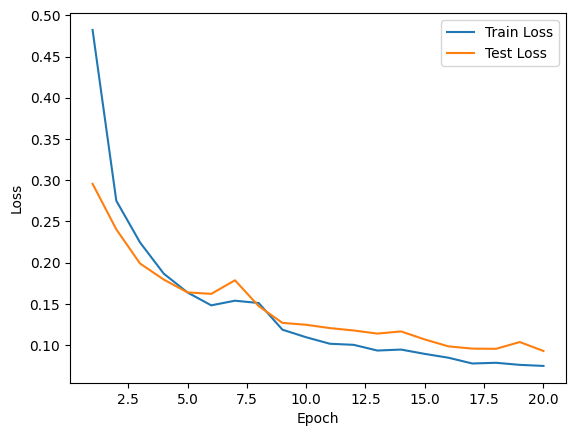

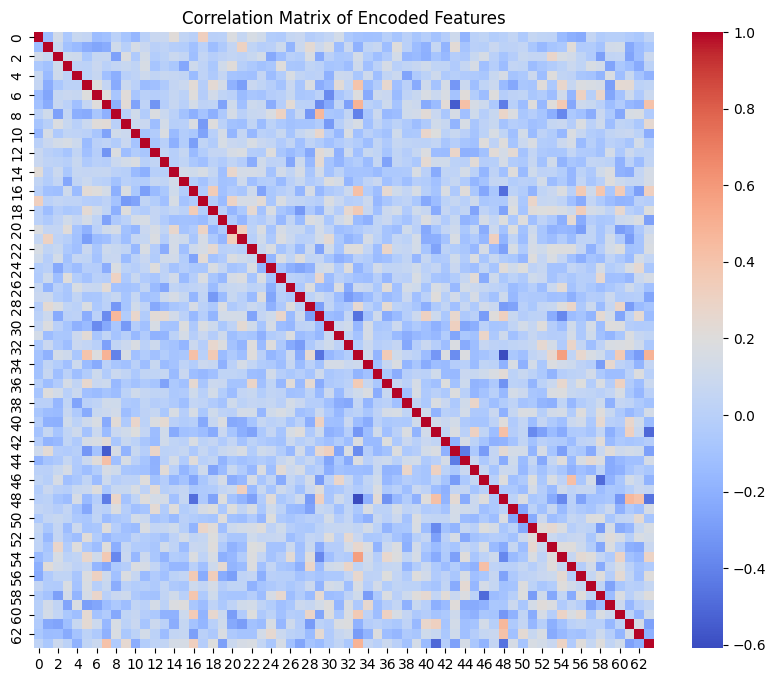

Covariance Matrix:
[[ 6.38687611 -0.91947221  0.86222714 ... -0.28312558 -0.45648707
   0.26476168]
 [-0.91947221  8.09133903  0.56651432 ... -1.73754985 -1.03390956
  -0.68299384]
 [ 0.86222714  0.56651432  7.85051648 ... -1.87948035 -0.98709872
   0.91211394]
 ...
 [-0.28312558 -1.73754985 -1.87948035 ...  6.59302702  1.05227863
  -2.5178294 ]
 [-0.45648707 -1.03390956 -0.98709872 ...  1.05227863  7.46909954
  -2.0078198 ]
 [ 0.26476168 -0.68299384  0.91211394 ... -2.5178294  -2.0078198
  13.04534056]]


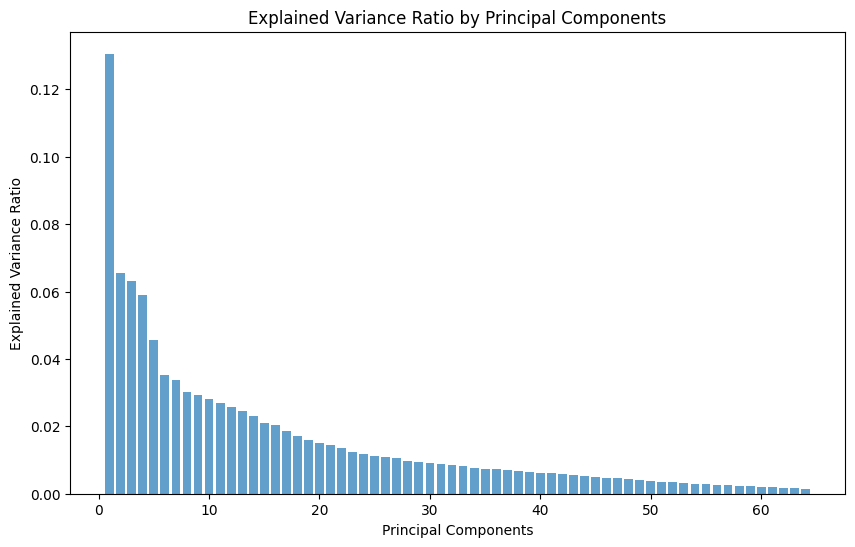

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

train_frames, test_frames, train_labels, test_labels = train_test_split(all_frames, all_labels, test_size=0.3, random_state=42)
train_frames = torch.tensor(train_frames, dtype=torch.float32)
test_frames = torch.tensor(test_frames, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_frames = train_frames.to(device)
test_frames = test_frames.to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = num_timesteps * num_features
encoding_dim = 64
learning_rate = 0.001
num_epochs = 20
batch_size = 32

model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_frames, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_frames, batch_size=batch_size, shuffle=False)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.view(data.size(0), -1).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.view(data.size(0), -1).to(device)
            output = model(data)
            loss = criterion(output, data)
            test_loss += loss.item() * data.size(0)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()

with torch.no_grad():
    encoded_features = []
    for data in train_loader:
        data = data.view(data.size(0), -1).to(device)
        encoded_output = model.encoder(data)
        encoded_features.append(encoded_output.cpu().numpy())
        
encoded_features = np.vstack(encoded_features)

correlation_matrix = np.corrcoef(encoded_features, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Encoded Features')
plt.show()

covariance_matrix = np.cov(encoded_features, rowvar=False)

print("Covariance Matrix:")
print(covariance_matrix)

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(encoded_features)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()
